# Visi Komputer ResNet50 untuk Menentukan Usia Seseorang di Perusahaan Waralaba <a id='intro'></a>

Suatu `waralaba supermarket` bernama `Good Seed` ingin mengetahui apakah `Data Science` dapat membantu mereka mematuhi hukum dengan memastikan bahwa mereka tidak menjual produk yang memiliki `batasan usia` kepada pelanggan `di bawah umur`. Toko-toko dari waralaba ini dilengkapi dengan kamera di area kasir yang akan menampilkan sinyal ketika seseorang membeli produk dengan `batasan usia`. Metode `visi komputer` bisa digunakan untuk menentukan `usia seseorang` dari `foto`. Kita akan membuat dan melatih model untuk menyelesaikan projek ini dengan menggunakan `deep learning`. Kita akan menggunakan `Convolutional Neural Network (CNN)` yang populer untuk mengenali foto yaitu `ResNet50` dengan menggunakan parameter dari `imagenet`. Metrik yang digunakan untuk evaluasi model diantaranya metrik `loss` adalah `MSE`, dan metrik `scoring` adalah `MAE`. Untuk mendapatkan model dengan kualitas yang bagus, maka metrik `MAE-validation` harus dibawah `8`.

# Konten <a id='back'></a>

* [Pendahuluan](#intro)
* [Konten](#back)
* [Tahap 1. Preparasi Data](#cont_1)
    * [1.1 Inisialisasi](#cont_2) 
    * [1.2 Memuat Data](#cont_3) 
    * [1.3 Separasi Data](#cont_4) 
* [Tahap 2. Analisis Data Eksploratif (EDA)](#cont_5)
* [Tahap 3. Melatih Model CNN](#cont_6)
    * [3.1 Mempersiapkan Skrip Eksekusi di Platform GPU](#cont_7) 
    * [3.2 Hasil Kalkulasi Platform GPU](#cont_8) 
* [Tahap 4. Kesimpulan](#cont_9)

# Preparasi Data <a id='cont_1'></a>

## Inisialisasi <a id='cont_2'></a>

Kita akan menjalankan beberapa modul seperti `pandas`, `matplotlib` dan `seaborn` untuk mengolah serta visualisasi data. Untuk melakukan `convolutional neural network (CNN)` menggunakan modul dari `deep learning - keras` yaitu `ResNet50` dan beberapa tools pendukungnya seperti berikut:

In [1]:
# memuat modul
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

## Memuat Data <a id='cont_3'></a>

Kita memiliki dua data yaitu `file image` dan `label image`. `Image file` berupa kumpulan `image/foto` yang tersimpan dalam satu `folder`, setiap foto dilengkapi dengan `nama_file` tersendiri. `Label image` berupa data tabular dalam format `.csv` yang berisi dua kolom yaitu `nama_file` dan `label` itu sendiri yaitu `usia` dari orang yang ada didalam `image/foto`. Untuk lebih detail:

- Folder `final_files` dengan `7,6 ribu foto`
- File `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age`

Mengingat jumlah `foto` terlalu banyak, kita akan membacanya secara terpisah atau tidak sekaligus menggunakan `ImageDataGenerator` untuk menghemat sumber daya komputasi.

In [2]:
# memuat path untuk data train dan dataset target (label)
face_path = '/datasets/faces/final_files/'
label_path = '/datasets/faces/labels.csv'

Untuk `data train` kita akan pecah menjadi beberapa `batch` dan setiap `batch` berisi `32 foto` dan kita ubah resolusi foto menjadi `[224 x 224]`.

In [3]:
# memuat dataset label
labels = pd.read_csv(label_path)

# memuat data train menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Terlihat kita mempunyai `image/foto` sebanyak `7591` foto. Selanjutnya kita akan mengecek dataset `label`.

In [4]:
# mengecek informasi dataset label
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# menampilkan sampel dataset label
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Kita memiliki `jumlah data` yang `sama` dengan `data train` sebanyak `7591 baris` dan `dua kolom` dengan `tanpa missing values`. Mari kita cek apakah terdapat duplikasi data.

In [6]:
# mengecek duplikasi data
labels.duplicated().sum()

0

Ternyata kita tidak memiliki duplikasi data pada `dataset label`.

## Separasi Data <a id='cont_4'></a>

Dikarenakan kita sudah membagi `data train` menjadi `batch` kecil menggunakan `ImageDataGenerator`, kita akan sesuaikan dengan cara separasi data menjadi dataset `fitur` dan dataset `target/label` seperti berikut. Mari kita pastikan `shape` dari masing-masing dataset sudah sesuai.

In [7]:
# melakukan separasi fitur dan label
feature, label = next(train_gen_flow)

In [8]:
# shape dari fitur
feature.shape

(32, 224, 224, 3)

Dari `batch-1` kita memiliki `32 foto` dengan resolusi `[224 x 224]` dan `3 channel`.

In [9]:
# shape dari label
label.shape

(32,)

Dari `batch-1` kita memiliki 1 kolom berisi `label` sebanyak `32 baris`. Kedua dataset sudah sesuai, mari kita analisis menggunakan `EDA`.

# Analisis Data Eksploratif (EDA) <a id='cont_5'></a>

Selanjutnya, kita akan melakukan `Analisis Data Eksploratif (EDA)` untuk melihat `distribusi usia` pada dataset dan juga mencocokan antara `image/foto` dengan `label` usia.

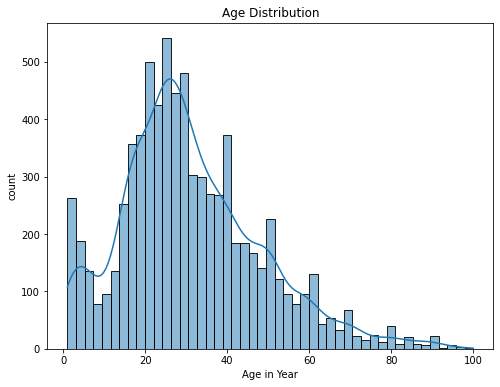

In [10]:
# visualisasi distribusi usia
plt.figure(figsize=(8,6))
sns.histplot(data=labels, x="real_age", kde=True)
plt.title('Age Distribution')
plt.xlabel('Age in Year')
plt.ylabel('count')
plt.show()

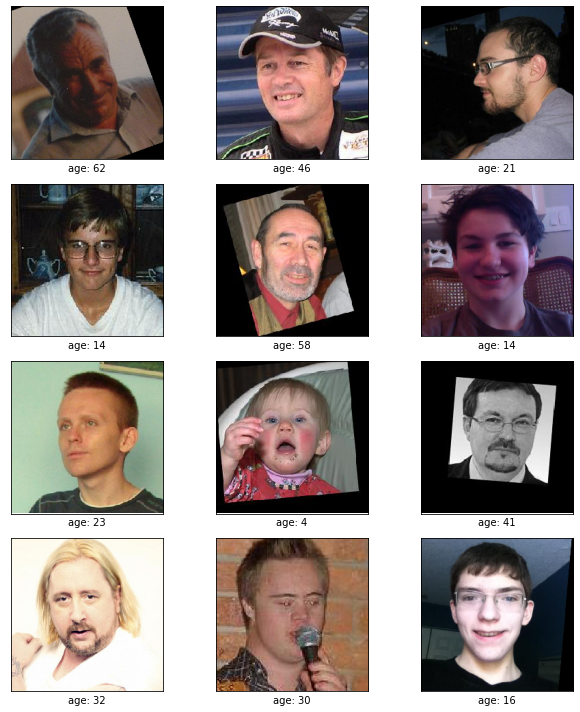

In [11]:
# mencocokan antara image/foto dengan label usia

# indeks spesial
idx = [13,2,14,4,15,6,22,8,24,17,20,21] 

# plot foto dan usia
fig = plt.figure(figsize=(10,10))
for i,val in enumerate(idx):
    ax = fig.add_subplot(4, 3, i+1)
    plt.imshow(feature[val])
    ax.set_xlabel(f'age: {label[val]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Berdasarkan `Analisis Data Exploratif (EDA)`, ditemukan bahwa `rentang usia` pada dataset dari `1` hingga `100` tahun dan kebanyakan berasal kisaran `usia 20` hingga `30 tahun`. Sedangkan pada pengecekan sampel fitur, antara `gambar` dan `label` sudah sesuai dengan yang diharapkan. Kita bisa melanjutkan ke proses berikutnya.

# Melatih Model CNN <a id='cont_6'></a>

Dikarenakan jumlah foto terlalu banyak, jika menggunakan laptop pribadi akan memakan cukup banyak waktu. Kita akan melakukan proses `running` menggunakan sumber daya dari `platform TripleTen` yang sudah menggunakan `GPU` untuk melatih `model CNN`. Dan hasil akan ditampilkan diakhir sesi ini.

Kita perlu membuat fungsi-fungsi untuk melatih `model CNN` mulai dari fungsi untuk memuat masing-masing dataset (`training` dan `test`), fungsi untuk mendefinisikan `model CNN` dan fungsi untuk melatih `model CNN`.

In [12]:
# membuat fungsi untuk memuat dataset `train`
def load_train(path):
    
    """
    Kode ini memuat bagian training set dari file path
    """
    
    # memuat path untuk data train dan label train
    face_path = path + 'final_files/'
    label_path = path + 'labels.csv'

    # memuat dataset label train
    labels = pd.read_csv(label_path)

    # memuat data train menggunakan ImageDataGenerator    
    train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    
    return train_gen_flow

In [13]:
# membuat fungsi untuk memuat dataset `test`
def load_test(path):
    
    """
    Kode ini memuat bagian validation set/test set dari file path
    """
    
    # memuat path untuk data test dan label test
    face_path = path + 'final_files/'
    label_path = path + 'labels.csv'

    # memuat dataset label test
    labels = pd.read_csv(label_path)

    # memuat data test menggunakan ImageDataGenerator   
    test_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return test_gen_flow

Disini kita akan mendefinisikan `model CNN`, `optimizer`, dan `metrik`. Model yang kita gunakan adalah `ResNet50` dimana kita akan melatihnya kembali `trainable=True` dengan menggunakan parameter `imagenet`. Optimizer yang akan kita gunakan adalah `Adam`, metrik `loss` adalah `MSE`, dan metrik `scoring` adalah `MAE`.

In [14]:
# membuat fungsi untuk mendefinisikan model CNN
def create_model(input_shape=(224,224,3)):
    
    """
    Kode ini mendefinisikan model
    """
    
    # rangkaian CNN
    resnet = ResNet50(input_shape=input_shape,
                 include_top=False,classes=1000,
                 weights='imagenet') 
    resnet.trainable = True
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    # optimizer dan metrik
    model.compile(
        optimizer=Adam(),
        loss='mean_squared_error',
        metrics=['mae'],
    )

    return model

Terakhir, kita akan membuat fungsi untuk menjalankan `training` dan `test` secara bersamaan dimana jumlah `epoch` yang kita gunakan sebanyak `20 epoch`.

In [15]:
# membuat fungsi untuk melatih dan menguji model CNN
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Melatih model dengan parameter yang diberikan
    """
    
    # training dan validasi model CNN
    model.fit(train_data,
            validation_data=test_data,
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch= len(train_data) if steps_per_epoch is None else steps_per_epoch,
            validation_steps= len(test_data) if validation_steps is None else validation_steps,
            verbose=2)

    return model

## Mempersiapkan Skrip Eksekusi di Platform GPU <a id='cont_7'></a>

Setelah kita mendefinisikan fungsi-fungsi yang diperlukan, kita akan membuat `skrip` untuk dijalankan pada `platform GPU`. Simpan file dalam ekstensi `run_model_on_gpu.py` dan uploat di `platform GPU`.

In [16]:
# mempersiapkan skrip untuk dijalankan pada platform GPU

init_str = """
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
"""

import inspect
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

## Hasil Kalkulasi Platform GPU <a id='cont_8'></a>

Ketika menjalankan file `run_model_on_gpu.py` di `Platform GPU`, platform akan menampilkan `progress` setiap `epoch`. `Epoch` tersebut akan menampilkan `skor metrik` untuk masing-masing dataset (`train` dan `test`) seperti berikut:

```python
Train for 238 steps, validate for 238 steps
Epoch 1/20
2023-08-18 10:16:58.593668: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-18 10:16:59.559367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 93s - loss: 201.9695 - mae: 10.8745 - val_loss: 354.6999 - val_mae: 13.9498
Epoch 2/20
238/238 - 73s - loss: 130.1995 - mae: 8.7367 - val_loss: 358.6957 - val_mae: 14.0053
Epoch 3/20
238/238 - 74s - loss: 103.5275 - mae: 7.7924 - val_loss: 232.8300 - val_mae: 11.2715
Epoch 4/20
238/238 - 74s - loss: 77.1647 - mae: 6.7313 - val_loss: 216.5618 - val_mae: 10.9379
Epoch 5/20
238/238 - 74s - loss: 61.0402 - mae: 6.0204 - val_loss: 71.4855 - val_mae: 6.5049
Epoch 6/20
238/238 - 74s - loss: 45.5029 - mae: 5.2287 - val_loss: 74.8317 - val_mae: 6.7152
Epoch 7/20
238/238 - 73s - loss: 33.5989 - mae: 4.5013 - val_loss: 98.2094 - val_mae: 7.9878
Epoch 8/20
238/238 - 73s - loss: 26.0695 - mae: 3.9656 - val_loss: 23.3316 - val_mae: 3.7125
Epoch 9/20
238/238 - 73s - loss: 19.8258 - mae: 3.4377 - val_loss: 20.9094 - val_mae: 3.4902
Epoch 10/20
238/238 - 73s - loss: 16.1180 - mae: 3.1117 - val_loss: 42.1019 - val_mae: 5.2717
Epoch 11/20
238/238 - 73s - loss: 12.8149 - mae: 2.7499 - val_loss: 23.3467 - val_mae: 3.5905
Epoch 12/20
238/238 - 73s - loss: 11.1544 - mae: 2.5586 - val_loss: 17.6547 - val_mae: 3.2560
Epoch 13/20
238/238 - 73s - loss: 10.7711 - mae: 2.5329 - val_loss: 19.6143 - val_mae: 3.2806
Epoch 14/20
238/238 - 73s - loss: 10.4065 - mae: 2.4674 - val_loss: 16.3027 - val_mae: 3.0909
Epoch 15/20
238/238 - 73s - loss: 10.6529 - mae: 2.4963 - val_loss: 27.4197 - val_mae: 3.9332
Epoch 16/20
238/238 - 73s - loss: 13.0407 - mae: 2.7802 - val_loss: 20.5680 - val_mae: 3.4702
Epoch 17/20
238/238 - 73s - loss: 13.6519 - mae: 2.8406 - val_loss: 22.2291 - val_mae: 3.5367
Epoch 18/20
238/238 - 73s - loss: 13.7342 - mae: 2.8402 - val_loss: 23.1255 - val_mae: 3.6062
Epoch 19/20
238/238 - 73s - loss: 13.2668 - mae: 2.7981 - val_loss: 49.3076 - val_mae: 5.0335
Epoch 20/20
238/238 - 73s - loss: 13.3556 - mae: 2.7826 - val_loss: 20.3960 - val_mae: 3.4985
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 36s - loss: 20.3960 - mae: 3.4985
Test MAE: 3.4985
```

Berdasarkan hasil diatas, hanya dengan menggunakan `20 epoch` kita bisa mendapatkan `MAE score` untuk dataset `test` sebesar `3.4985` yang sudah memenuhi kualifikasi model yang diharapkan, dimana `MAE Score (test) < 8`.

# Kesimpulan <a id='cont_9'></a>

Pada projek ini, kita sudah berhasil membuat dan melatih model `deep learning` menggunakan `ResNet50` untuk prediksi `umur` seseorang berdasarkan `image`. Dataset sudah siap digunakan untuk dilatih, lengkap dengan label dari masing-masing `image`. Beberapa kesimpulan umum dari projek ini diantaranya:
- Jumlah `image` pada dataset sebanyak `7591 image-3channel` dengan label terpisah pada `dataframe`.
- Dataset berasal dari rentang `umur` mulai dari `1` hingga `100` tahun dengan komposisi terbanyak berada pada `umur` berkisar `20 hingga 30 tahun`.
- Pengecekan sampel dataset `train` sudah sesuai dengan label yang diberikan.
- Model yang digunakan adalah model `ResNet50` dengan parametrik jumlah `batch=32`, `loss=mean_squared_error`, dan metrik evaluasi `mean_absolute_error`.
- Target skor `mean_absolute_error < 8` sudah tercapai pada `epochs=20` menghasilkan `mae_train=3.4985` dan `mae_test=3.4985`.